In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data
historical_data = pd.read_csv("doordash_historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
from datetime import datetime
historical_data["created_at"] = pd.to_datetime(historical_data["created_at"])
historical_data["actual_delivery_time"]=pd.to_datetime(historical_data["actual_delivery_time"])
historical_data["created_at"].head()

0   2015-02-06 22:24:17
1   2015-02-10 21:49:25
2   2015-01-22 20:39:28
3   2015-02-03 21:21:45
4   2015-02-15 02:40:36
Name: created_at, dtype: datetime64[ns]

In [5]:
# create the target variable for regression
from datetime import datetime
onehour = pd.Timedelta(seconds=3600)
historical_data["actual_total_delivery_duration"]=(((historical_data["actual_delivery_time"]-historical_data["created_at"])/ onehour)*3600)
historical_data["actual_total_delivery_duration"].head()

0    3779.0
1    4024.0
2    1781.0
3    3075.0
4    2390.0
Name: actual_total_delivery_duration, dtype: float64

In [6]:
historical_data["busy_dashers_ratio"]= historical_data["total_busy_dashers"]/historical_data["total_onshift_dashers"]

In [7]:
historical_data["estimated_non_prep_duration"]=(historical_data["estimated_store_to_consumer_driving_duration"]+historical_data["estimated_order_place_duration"])

In [8]:
# check ids and decide whether to encode or not
historical_data["market_id"].nunique()

6

In [9]:
historical_data["store_id"].nunique()

6743

In [10]:
historical_data["order_protocol"].nunique()

7

In [11]:
# creat dummies for order protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix("order_protocol")

In [12]:
order_protocol_dummies.head()

,order_protocol1.0,order_protocol2.0,order_protocol3.0,order_protocol4.0,order_protocol5.0,order_protocol6.0,order_protocol7.0
0,True,False,False,False,False,False,False
1,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [13]:
# creat dummies for market id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix("market_id")

In [14]:
market_id_dummies.head()

,market_id1.0,market_id2.0,market_id3.0,market_id4.0,market_id5.0,market_id6.0
0,True,False,False,False,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False


In [15]:
# creat a reference dictionary with most repeated categories of each store to fill null rows where it is possible
store_id_unique = historical_data["store_id"].unique().tolist()
store_id_and_category = {store_id:historical_data[historical_data.store_id==store_id].store_primary_category.mode()for store_id in store_id_unique}

In [16]:
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
# fill null values
historical_data["nan_free_store_primary_category"]=historical_data.store_id.apply(fill)

In [17]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix("category_")
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time,actual_total_delivery_duration
train_df=historical_data.drop(columns = 
["created_at", "order_protocol","market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category"])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [19]:
train_df.shape

(197428, 13)

In [20]:
# concate all columns together abd convert the data type to float
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
train_df.describe()

C:\Users\artpe\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.665833,1822.968994,1.629398,522.068542,558.358337,34.524193,32.146065,52.657368,90.211159,219.350143,...,0.028535,0.013687,0.073625,0.105705,0.027175,0.189502,0.034246,0.037816,0.064904,0.173167
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
train_df["busy_dashers_ratio"].describe()

C:\Users\artpe\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [23]:
# check infinity values with using nump isfinite() function
np.where(np.any(-np.isfinite(train_df), axis=0)==True)

(array([ 5,  6,  7,  9, 10, 11, 12], dtype=int64),)

In [24]:
# replace inf values with nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop nans
train_df.dropna(inplace=True)

In [25]:
train_df["busy_dashers_ratio"].describe()

count    177070.000000
mean          0.949947
std           0.406551
min         -13.000000
25%           0.826923
50%           0.962264
75%           1.000000
max          31.000000
Name: busy_dashers_ratio, dtype: float64

In [26]:
train_df.shape

(177070, 100)

In [27]:
# colinearlity means both of your values ahve the same effect of your model
# Heatmap
corr = train_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

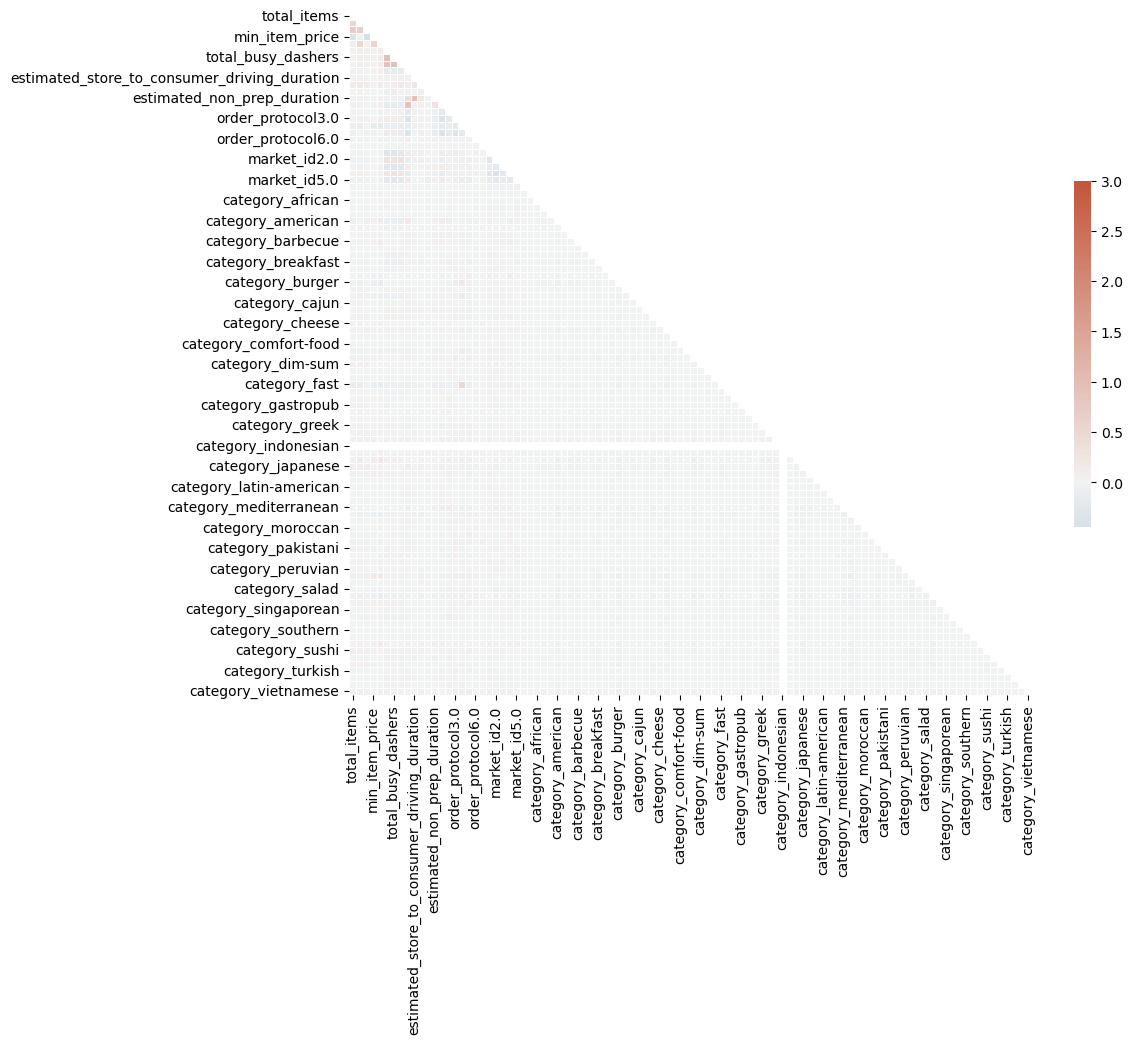

In [28]:
# set up a matplotlib figure
f, ax = plt.subplots(figsize=(11,9))
# add a custom diverging colormap
cmap=sns.diverging_palette(230, 20, as_cmap=True)
# add a heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [29]:
# there is colinbeality at category_indonesian
train_df["category_indonesian"].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [30]:
# get redundant pairs
def get_redundant_pairs(df):
    """Get diagonal and lower traingular pairs of correlation matrix"""
    pairs_to_drop=set()
    cols=df.columns
    for i in range (0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [31]:
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the describing order and return n highest results"""
    au_corr=df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr=au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [32]:
print ("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol1.0              0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol4.0                             category_fast                  0.489946
num_distinct_items          

In [33]:
# drop correlated columns
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df=historical_data.drop(columns=["created_at","market_id","store_id","store_primary_category",
                                       "actual_delivery_time","order_protocol","nan_free_store_primary_category"])

In [34]:
#dont concat market id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers","total_busy_dashers","category_indonesian","estimated_non_prep_duration"])
train_df.dropna(inplace=True)

In [35]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4,3441,4,557,1239,21.0,446,861.0,3779.0,0.424242,...,False,False,False,False,False,False,False,False,False,False
1,1,1900,1,1400,1400,2.0,446,690.0,4024.0,2.000000,...,False,False,False,False,False,False,False,False,False,False
2,1,1900,1,1900,1900,0.0,446,690.0,1781.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,6,6900,5,600,1800,2.0,446,289.0,3075.0,1.000000,...,False,False,False,False,False,False,False,False,False,False
4,3,3900,3,1100,1600,9.0,446,650.0,2390.0,1.000000,...,False,False,False,False,False,False,False,False,False,False


In [36]:
train_df.shape

(177109, 90)

In [37]:
# drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df=historical_data.drop(columns=["created_at","market_id","store_id","store_primary_category",
                                       "actual_delivery_time","order_protocol","nan_free_store_primary_category"])

#dont concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)

# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers","total_busy_dashers","category_indonesian","estimated_non_prep_duration"])

# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

train_df.head()

print ("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170

In [38]:
# creat new features
train_df["percent_distinct_item_of_total"]=train_df["num_distinct_items"]/train_df["total_items"]
train_df["avg_price_per_item"]=train_df["subtotal"]/train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))


Top Absolute Correlation
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.175

In [39]:
train_df["price_range_of_items"]=train_df["max_item_price"]-train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlation")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlation
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.157

In [40]:
train_df.shape

(177070, 82)

In [41]:
# Removing multi-collinearity
# Use the Variance Inflation Factor (Vif)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
# creat a custom VIF function
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data=pd.DataFrame()
    vif_data["feature"]=features
    vif_data["VIF"]=[variance_inflation_factor(train_df[features].values, i)for i in range(len(features))]
    return vif_data.sort_values(by=["VIF"]).reset_index(drop=True)

In [43]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data=compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000373
1,category_chocolate,1.000508
2,category_belgian,1.000771
3,category_russian,1.003245
4,category_african,1.003825
...,...,...
76,busy_dashers_ratio,6.369577
77,category_american,7.033605
78,estimated_store_to_consumer_driving_duration,7.210894
79,estimated_order_place_duration,13.470940


In [44]:
# use the while loop to drop feature with vif above 20

multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data["feature"].values.tolist()[-1]
    print("i will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF>20]) == 0 else True
    
selected_features = vif_data["feature"].values.tolist()
vif_data

i will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000224
1,category_chocolate,1.000377
2,category_belgian,1.000472
3,category_russian,1.002037
4,category_gluten-free,1.002381
...,...,...
75,category_american,4.505930
76,avg_price_per_item,5.958991
77,busy_dashers_ratio,6.357857
78,estimated_store_to_consumer_driving_duration,7.192701


In [45]:
# feature selection Using PCA and Random forest method using GINNs importance

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# selected feature are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42)


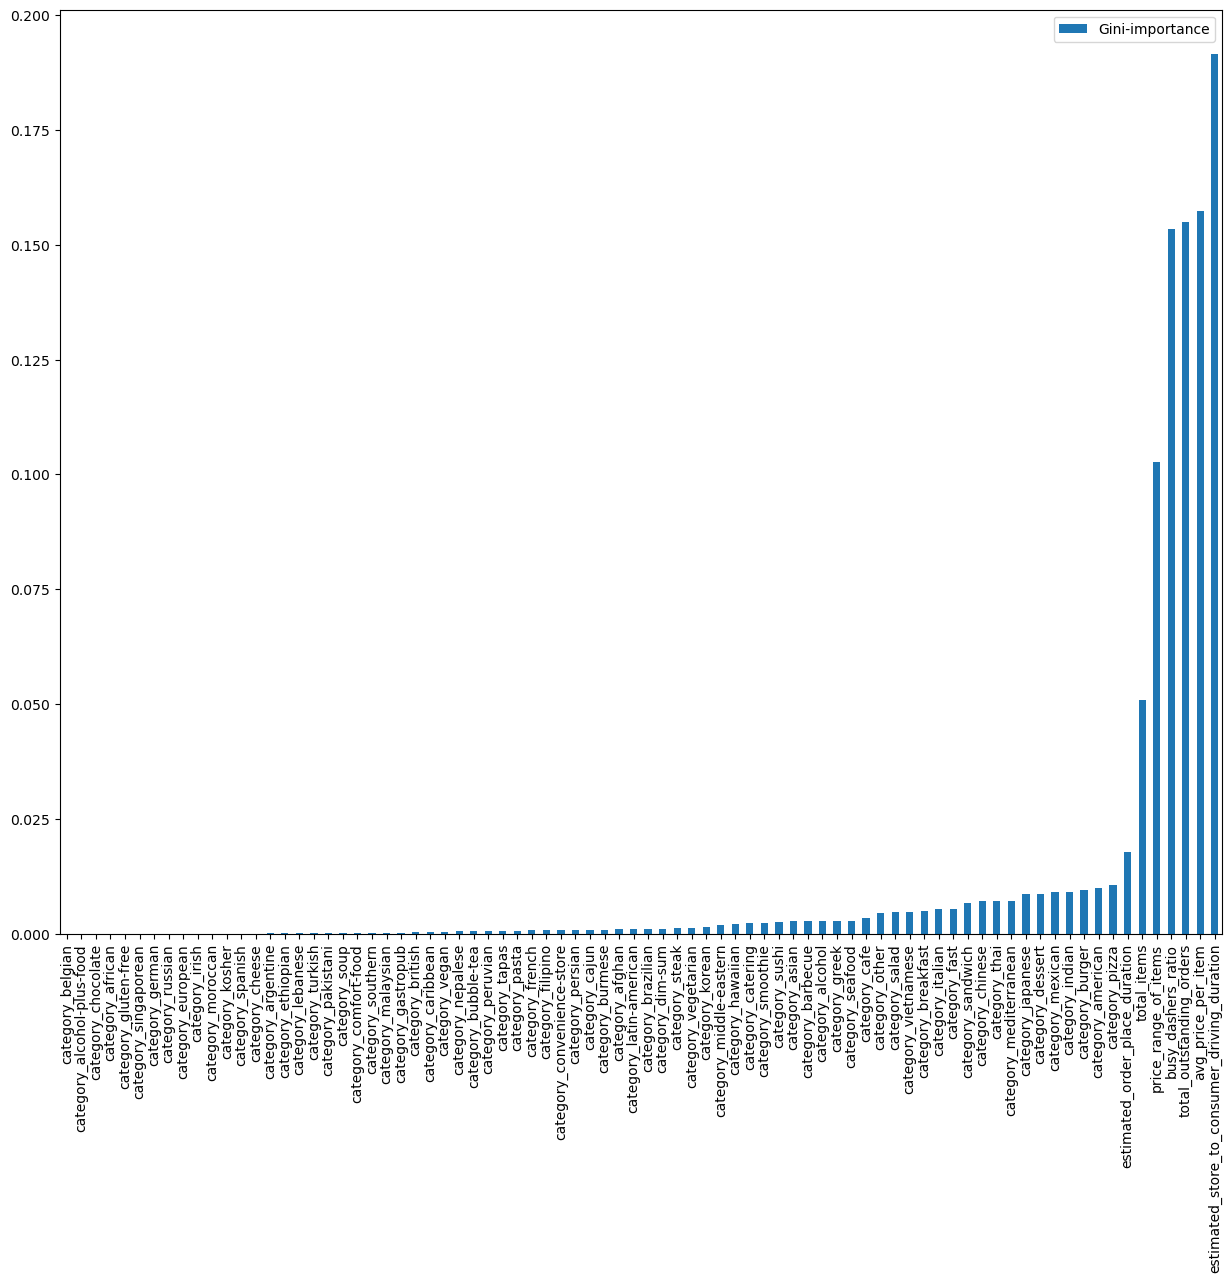

In [47]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

# a dict to hold feature_name: feature_importance
feats={}
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature]=importance # add the name/ value pair
importances=pd.DataFrame.from_dict(feats, orient="index").rename(columns={0: "Gini-importance"})
importances.sort_values(by="Gini-importance").plot(kind="bar", rot=90, figsize=(15,12))
plt.show()


TypeError: _AxesBase.set_xlim() takes from 1 to 3 positional arguments but 4 were given

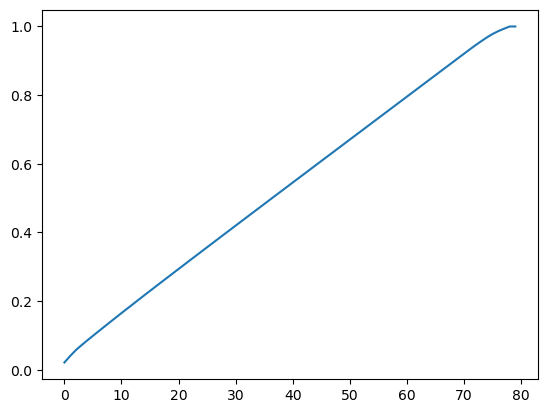

In [48]:
# uSING pca TO REDUCE THE FEATURES
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train = X_train.values
X_Train=np.asarray(X_Train)

# Finding normalized array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca=PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show

In [49]:
# feature scaling: it helps to compare different scaled features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# std scaler
# minmax scaler(normalization)

In [50]:
def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler=scaler
    X_scaler.fit(X=X, y=y)
    X_scaled=X_scaler.transform(X)
    y_scaler=scaler
    y_scaler.fit(y.values.reshape(-1,1))
    y_scaled=y_scaler.transform(y.values.reshape(-1,1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [51]:
# example of using the function with the minmax scaler
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

In [52]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
    
    #return RMSE with squared False
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in "+model_name)
    
    return rmse_error, y_predict

In [53]:
#Using classical machine learning modek

In [54]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

C:\ProgramData\anaconda\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [55]:
# define a custom function which can work on multiple machine learning models

def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error="'{}'.format(train_error)+"in" +model_name)
        print("Test error="'{}'.format(test_error)+"in" +model_name)
    trained_model = model
    return trained_model, y_predict, train_error, test_error
        


In [56]:
from math import sqrt

# define dict to store our parameters

pred_dict = {
    "regression_model":[],
    "feature_set":[],
    "scaler_name":[],
    "RMSE":[],
}

regression_models = {
    "Ridge":linear_model.Ridge(),
    "DecisionTree":tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest":RandomForestRegressor(),
    "XGBoost":XGBRegressor(),
    "LGBM":LGBMRegressor(),
    "MLP":MLPRegressor(),
    
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by="Gini-importance")[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by="Gini-importance")[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by="Gini-importance")[-10:].index.tolist(),
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

# Write 3 for loops inside each other

for feature_set_name in feature_sets.keys():
    feature_set= feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f".............scaled with {scaler_name}.............included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name=="NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
                
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled, regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                
            pred_dict["regression_model"].append( model_name)
            pred_dict["feature_set"].append( feature_set_name)
            pred_dict["scaler_name"].append( scaler_name)
            pred_dict["RMSE"].append( rmse_error)

.............scaled with Standard scaler.............included columns are full dataset

Train error=0.767963171005249inRidge
Test error=1.4719302654266357inRidge
Error = 2053.69873046875 in Ridge
Train error=0.7653021361303404inDecisionTree
Test error=1.4744739559914226inDecisionTree
Error = 2057.2476687088733 in DecisionTree
Train error=0.2822595453364364inRandomForest
Test error=1.4678104272055683inRandomForest
Error = 2047.9504345964408 in RandomForest
Train error=0.6924042105674744inXGBoost
Test error=1.4594244956970215inXGBoost
Error = 2036.2498779296875 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 70
[LightGBM] [Info] Start training from score -0.002379
Train error=0.7

C:\ProgramData\anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42533e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error=1071.4971923828125inRidge
Test error=2053.692626953125inRidge
Train error=1067.7815291116704inDecisionTree
Test error=2057.2476684096064inDecisionTree
Train error=400.08856566188433inRandomForest
Test error=2048.2848921850155inRandomForest
Train error=968.2471313476562inXGBoost
Test error=2036.43212890625inXGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 70
[LightGBM] [Info] Start training from score 2851.342096
Train error=1017.5549840201221inLGBM
Test error=2034.461097275308inLGBM


C:\ProgramData\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error=1053.4617919921875inMLP
Test error=2046.8026123046875inMLP
.............scaled with Standard scaler.............included columns are selected_features_40

Train error=0.7685800194740295inRidge
Test error=1.47214937210083inRidge
Error = 2054.00439453125 in Ridge
Train error=0.7653050277966773inDecisionTree
Test error=1.4739590156893994inDecisionTree
Error = 2056.5292024696128 in DecisionTree
Train error=0.28471463684477283inRandomForest
Test error=1.4684403248254467inRandomForest
Error = 2048.8292940694996 in RandomForest
Train error=0.6926604509353638inXGBoost
Test error=1.4588536024093628inXGBoost
Error = 2035.453369140625 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 141656, number of used feat

C:\ProgramData\anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55923e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error=1072.35498046875inRidge
Test error=2054.00439453125inRidge
Train error=1067.785563647774inDecisionTree
Test error=2056.529202224364inDecisionTree
Train error=396.4742365664486inRandomForest
Test error=2047.854126144135inRandomForest
Train error=965.6858520507812inXGBoost
Test error=2035.7642822265625inXGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 40
[LightGBM] [Info] Start training from score 2851.342096
Train error=1017.1430421117441inLGBM
Test error=2034.8058530174258inLGBM


C:\ProgramData\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error=1055.527099609375inMLP
Test error=2047.67626953125inMLP
.............scaled with Standard scaler.............included columns are selected_features_20

Train error=0.770122230052948inRidge
Test error=1.4731249809265137inRidge
Error = 2055.36572265625 in Ridge
Train error=0.7662722630951128inDecisionTree
Test error=1.4725837048094073inDecisionTree
Error = 2054.610311207463 in DecisionTree
Train error=0.28351059717515126inRandomForest
Test error=1.4686117051919998inRandomForest
Error = 2049.068411120628 in RandomForest
Train error=0.6905712485313416inXGBoost
Test error=1.4604161977767944inXGBoost
Error = 2037.6336669921875 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 141656, number of used feature

C:\ProgramData\anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43858e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error=1069.1350906055598inDecisionTree
Test error=2054.610311170708inDecisionTree
Train error=399.093346724179inRandomForest
Test error=2049.5174546070857inRandomForest
Train error=966.1651000976562inXGBoost
Test error=2036.249267578125inXGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1372
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 20
[LightGBM] [Info] Start training from score 2851.342096
Train error=1018.9600610110249inLGBM
Test error=2035.9494403356318inLGBM
Train error=1056.749267578125inMLP
Test error=2049.177001953125inMLP
.............scaled with Standard scaler.............included columns are selected_features_10

Train error=0.7717141509056091inRidge
Test error=1.4739872217178345inRidge
Error = 2056.568359375 in Ridge
Train error=0.7663420076820632inDecisionTree
Test error=1

C:\ProgramData\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error=1061.7919921875inMLP
Test error=2051.977783203125inMLP


In [57]:
pred_df = pd.DataFrame(pred_dict)

In [58]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,2053.698730
1,DecisionTree,full dataset,Standard scaler,2057.247669
2,RandomForest,full dataset,Standard scaler,2047.950435
3,XGBoost,full dataset,Standard scaler,2036.249878
4,LGBM,full dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2115.536133
68,RandomForest,selected_features_10,NotScale,2115.536133
69,XGBoost,selected_features_10,NotScale,2115.536133
70,LGBM,selected_features_10,NotScale,2115.536133


<Axes: >

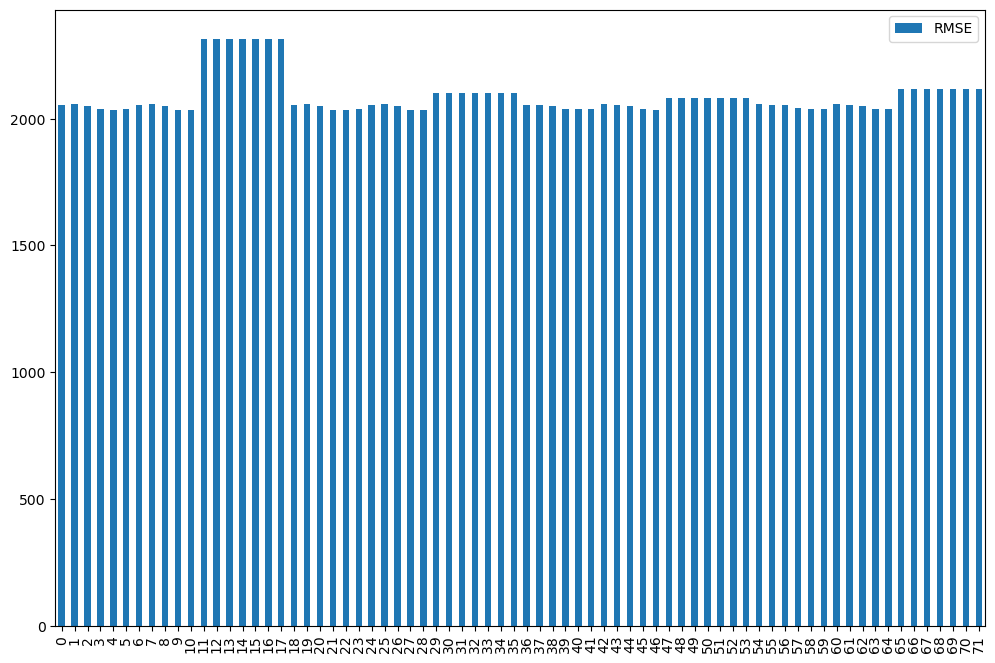

In [59]:
pred_df.plot(kind="bar", figsize=(12,8))

In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177070 entries, 0 to 197427
Data columns (total 82 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   total_items                                   177070 non-null  float32
 1   total_outstanding_orders                      177070 non-null  float32
 2   estimated_order_place_duration                177070 non-null  float32
 3   estimated_store_to_consumer_driving_duration  177070 non-null  float32
 4   actual_total_delivery_duration                177070 non-null  float32
 5   busy_dashers_ratio                            177070 non-null  float32
 6   category_afghan                               177070 non-null  float32
 7   category_african                              177070 non-null  float32
 8   category_alcohol                              177070 non-null  float32
 9   category_alcohol-plus-food                    177070 

In [61]:
# let change the problem abit by predicting prep_duration and then calculate actual_total_delivery_duration
train_df["prep_time"]=train_df["actual_total_delivery_duration"]-train_df["estimated_store_to_consumer_driving_duration"]-train_df["estimated_order_place_duration"]

# scaler =Standard
# feature size =40

scalers ={
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by="Gini-importance")[-40:].index.tolist(),
}


In [62]:
# Write 3 for loops inside each other

for feature_set_name in feature_sets.keys():
    feature_set= feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f".............scaled with {scaler_name}.............included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # drop estimated_store_to_consumer_driving_duration and estiamted_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration","estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index
                
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled, regression_models[model_name], model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                
            pred_dict["regression_model"].append( model_name)
            pred_dict["feature_set"].append( feature_set_name)
            pred_dict["scaler_name"].append( scaler_name)
            pred_dict["RMSE"].append( rmse_error)

.............scaled with Standard scaler.............included columns are selected_features_40

Train error=0.786737859249115inRidge
Test error=1.5045511722564697inRidge
Error = 2055.40771484375 in Ridge
Train error=0.7693331400114065inDecisionTree
Test error=1.5103578588350464inDecisionTree
Error = 2063.3402827182467 in DecisionTree
Train error=0.2953657137033719inRandomForest
Test error=1.5029539642359375inRandomForest
Error = 2053.225623476354 in RandomForest
Train error=0.7115257978439331inXGBoost
Test error=1.4916772842407227inXGBoost
Error = 2037.8203125 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 38
[LightGBM] [Info] Start training from score -0.002301
Train error=0.

In [63]:
scalers ={
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by="Gini-importance")[-40:].index.tolist(),
}

# continue with the best performing model
regression_models ={
    "LGBM": LGBMRegressor(),
}
# Write 3 for loops inside each other

for feature_set_name in feature_sets.keys():
    feature_set= feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f".............scaled with {scaler_name}.............included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # drop estimated_store_to_consumer_driving_duration and estiamted_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration","estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index
                
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled, regression_models[model_name], model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                
            pred_dict["regression_model"].append( model_name)
            pred_dict["feature_set"].append( feature_set_name)
            pred_dict["scaler_name"].append( scaler_name)
            pred_dict["RMSE"].append( rmse_error)

.............scaled with Standard scaler.............included columns are selected_features_40

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 141656, number of used features: 38
[LightGBM] [Info] Start training from score -0.002301
Train error=0.7484992880216514inLGBM
Test error=1.490142572482501inLGBM
Error = 2035.7236370573405 in LGBM


In [64]:
# choose the perform model and extract the predictions for preparation duration
pred_values_dict={
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(),
    "pred_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
}

In [65]:
# convert dict to df
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,pred_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [66]:
# sum predictions up with non preparation activities such as order placing and driving
values_df["sum_total_delivery_duration"]=values_df["pred_duration_prediction"]+values_df["estimated_store_to_consumer_driving_duration"]+values_df["estimated_order_place_duration"]
values_df

,actual_total_delivery_duration,pred_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [67]:
# calculate the mse between the sum_total_delivery_duration and the actual_total_delivery_duration
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

2035.7236370573405

In [68]:
# what if we use another regression to obtain the actual total delivery duration
X= values_df[["pred_duration_prediction", "estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y= values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
regression_models = {
    "Ridge":linear_model.Ridge(),
    "DecisionTree":tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest":RandomForestRegressor(),
    "XGBoost":XGBRegressor(),
    "LGBM":LGBMRegressor(),
    "MLP":MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _=make_regression(
        X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print("RMSE of:", model_name, mean_squared_error(y_test, y_predict, squared=False))

RMSE of: Ridge 986.6912510344928
RMSE of: DecisionTree 1235.578088153976
RMSE of: RandomForest 1355.6152468498149
RMSE of: XGBoost 1370.412425918564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 28331, number of used features: 3
[LightGBM] [Info] Start training from score 2869.174261
RMSE of: LGBM 1079.2949179771774
RMSE of: MLP 987.3369027556856


In [70]:
# use deep learning method to compare


In [71]:
# load the library
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

In [80]:
# Neural networks
def create_model(feature_set_size):
    
    # define the model
    model= Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation="relu"))
    model.add(Dense(1, activation="linear"))
    
    #  compile the model
    model.compile(optimizer="sgd", loss="mse",
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [81]:
print(f".............scaled with {scaler_name}.............included columns are {feature_set_name}")
print("")
model_name ="ANN"
scaler_name="Standard scaler"
X= values_df[["pred_duration_prediction", "estimated_store_to_consumer_driving_duration","estimated_order_place_duration"]]
y= values_df["actual_total_delivery_duration"]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)
# scale
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            
print("feature_set_size", X_train_scaled.shape[1])
            
model=create_model(feature_set_size=X_train_scaled.shape[1])
history=model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred=model.predict(X_test_scaled)
rmse_error=rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
                
pred_dict["regression_model"].append( model_name)
pred_dict["feature_set"].append( feature_set_name)
pred_dict["scaler_name"].append( scaler_name)
pred_dict["RMSE"].append( rmse_error)

.............scaled with Standard scaler.............included columns are selected_features_40

feature_set_size 3
Epoch 1/100
443/443 [==============================] - 5s 3ms/step - loss: 1.1421 - root_mean_squared_error: 1.0687
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1216 - root_mean_squared_error: 1.0591
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1203 - root_mean_squared_error: 1.0585
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1199 - root_mean_squared_error: 1.0583
Epoch 5/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1197 - root_mean_squared_error: 1.0581
Epoch 6/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1197 - root_mean_squared_error: 1.0582
Epoch 7/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1192 - root_mean_squared_error: 1.0579
Epoch 8/100
443/443 [==============================] - 1s 2ms/step - loss

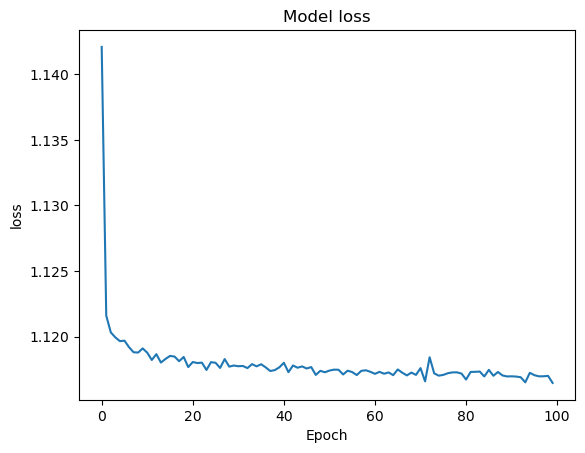

In [82]:
# a graph of epoch against loss
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.show()